# Machine Learning без х*йни

Сначала захреначим кучу всяких макросов

In [1]:
%load_ext autoreload 
%autoreload 2

%matplotlib inline

Дальше импортнем библиотеки... Недостоющие библиотеке устанавливаем через pip install <название пакета>. Название пакет выдается при ошибке. Если не получается установить - то гуглим ошибку. Возможно название пакета отличается от выданного в ошибке.

In [1]:

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

Создадим переменную, которая будет содержать путь к нашим данным. Создаем папку, кладем данные с kaggle(подробнее читайте ниже), прописываем путь до папки с данными.

In [2]:
PATH = "data/bulldozers/"

In [4]:
!ls {PATH}

Train.csv


## Данные 

Для теста берем данные из соревнования Blue Book for Bulldozers Kaggle Competition, цель которого предсказать стоимость оборудования на аукционе на основе данных о его предназначении, конфигурации и использовании. Данные взяты с прошедших аукционов.

### ...Подробнее о данных

Kaggle немного рассказывает о некоторых полях данных. На https://www.kaggle.com/c/bluebook-for-bulldozers/data написано, что данные разбиты на три части:
- **Train.csv** - тренировочный датасет, который содержит данные до 2011
- **Valid.csv** - validation set, это основной датасет, на котором происходит проверка алгоритмов в соревнованиях Kaggle. Предсказания на основе него попадают в таблицу leaderboard.
- **Test.csv** - Датасет загружается за неделю до конца соревнований и на его основе считается твой final rank в таблице результатов.

Ключевые поля в train.csv:
- SalesID: уникальный ID продажи
- MachineID: Уникальный ID машины. Машина может быть продана несколько раз
- saleprice: Цена продажи машины на аукционе (есть только в train.csv)
- saledate: Дата продажи.

Обычно всегда стоит посмотреть на то, как реально выглядят данные,чтобы понимать их структуру, что содержится в полях и т.д. Создадим переменную `df_raw`, в которую загрузим датасет `Train.csv`.`pd.read_csv` - считываемт файл формата .csv и создает датасет. В данной функции присутствует множество параметров по-умолчанию(подробнее читайте документацию), но обсудим только используемые: 1) путь до файла -  тут, думаю, все понятно. 2) Отлючаем оптимизацию по памяти `low_memory`,так как в случае использования данного функционала возможно смешивание типов, в то время как мы стараемся всё четко структуризировать. 3) `parse_dates` параметр принимает имя столбца и делает его данные типом `datetime` (формат даты). Об этом мы поговорим чуть позже.

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

Использовавав `?` перед вызовом функции, мы можем почитать документацию о ней.

In [6]:
?pd.read_csv()

Зафигачим быстренько функцию для вывода данных. Через `def` создаём функцию отображения нашей таблицы. Операторы `with` следят за тем, чтобы таблица входила в размеры 1000 х 1000. Функция `display` производит отображение таблицы (что то типа умного print)

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [8]:
?display()

`.transpose()` инвертирует таблицу так, чтобы заголовки столбцов были слева. Чётко говоря - транспонирует таблицу.

`df_raw.head()` - устанавливает сколько строк от начала нам вывести, но так как мы транспонируем таблицу, - то устанавливает сколько столбцов нам вывести.

In [9]:
display_all(df_raw.head(10).transpose())

,0,1,2,3,4,5,6,7,8,9
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275
SalePrice,66000,57000,10000,38500,11000,26500,21000,27000,21500,65000
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883
datasource,121,121,121,121,121,121,121,121,121,121
auctioneerID,3,3,3,3,3,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007,2004,1993,2001,2008,1000
MachineHoursCurrentMeter,68,4640,2838,3486,722,508,11540,4883,302,20700
UsageBand,Low,Low,High,High,Medium,Low,High,High,Low,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00,2008-12-18 00:00:00,2004-08-26 00:00:00,2005-11-17 00:00:00,2009-08-27 00:00:00,2007-08-09 00:00:00


В нашем случае мы видим очень много всяких солбцов с кучей непонятных данных. На самом деле, нас интересует только `SalePrice` и она называется dependent variable. То есть, все остальные данные влияют на формирование нашей цены.



Можно обратиться к полю `shape`, чтобы понять размер таблицы...

In [10]:
df_raw.shape

(401125, 53)

Теперь глянем на тип данных, который содержится в таблице. Как видим, они разные. 

In [11]:
df_raw.dtypes

SalesID                              int64
SalePrice                            int64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type   

Например, мы можем сменить тип данных в таблице. я не буду ничего менять, просто заменю на тот же, чтобы ничего не сломать. :)

`df_raw.saledate.apply()` функция `.apply` преобразует поле `saledate` в формат даты представленный ниже через `pd.to_datetime`. С помощью `.apply` можно преобразовывать любое поле, как вам удобно(в большинстве случаев)

In [12]:
df_raw.saledate.apply(pd.to_datetime)

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
5        2008-12-18
6        2004-08-26
7        2005-11-17
8        2009-08-27
9        2007-08-09
10       2008-08-21
11       2006-08-24
12       2005-10-20
13       2006-01-26
14       2006-01-03
15       2006-11-16
16       2007-06-14
17       2010-01-28
18       2006-03-09
19       2005-11-17
20       2006-05-18
21       2006-10-19
22       2007-10-25
23       2006-10-19
24       2004-05-20
25       2006-03-09
26       2006-03-09
27       2007-02-22
28       2007-08-09
29       2006-06-01
            ...    
401095   2011-12-14
401096   2011-09-15
401097   2011-10-28
401098   2011-08-16
401099   2011-12-14
401100   2011-08-16
401101   2011-12-14
401102   2011-08-16
401103   2011-09-15
401104   2011-08-16
401105   2011-10-25
401106   2011-08-16
401107   2011-09-15
401108   2011-08-16
401109   2011-08-16
401110   2011-09-15
401111   2011-10-25
401112   2011-10-25
401113   2011-10-25


Метод `info()` позволяет получить краткую сводку по нашему набору данных. Посмотреть, где есть нулевые значения в столбцах и тд. Их можно заполнить с помощью метода `fillna()`

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

Дальше нам стоит глянуть на то, как Kaggle будет оценивать наше решение. На сайте указано RMSLE. Это значит, что недообучение будет штрафоваться больше чем переобучение алгоритма. В формулы я углубляться не буду. Нам по.

Case a) : Pi = 600, Ai = 1000 RMSE = 400, RMSLE = 0.5108

Case b) : Pi = 1400, Ai = 1000 RMSE = 400, RMSLE = 0.3365

Самое важное здесь то, что RMSLE в отличие от RMSE использует log. Поэтому нам нужно работать с log данными. В это лучше не вдаваться, а принять как есть - нам нужен натуральный логарифм `.log` от поля SalePrice (цены).

In [14]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [15]:
?np.log()

## Random Forest

Теперь приступим непосредственно к ML. Что такое Random forest мы разберем позднее. Сейчас можно просто сделать вид, что это своего рода универсальная ML техника. Которая позволяет предсказывать различные категории данных. Будь то классификация кошек и собак или предсказание цены. Имеет хорошую толерантность к overfit. Мы потом разберем это подробнее. Для него не нужно разделять validation set - он может сказать о том, как хорошо он обобщает/предсказывает/выделяет имея только один набор данных. У него еще много всяких статистических допущений и т.д. Это все очень круто и именно эта техника хорошее место для старта.  

Если ваш первый random forest дает очень мало полезной информации, то проблема сокроее всего в ваших данных. Т.к. он был спроектирован с той целью, чтобы работать "из коробки". 

In [16]:
RandomForestRegressor
RandomForestClassifier

sklearn.ensemble.forest.RandomForestClassifier

Итак, мы видим, что `RandomForestRegressor` идет из библы sklearn. Это один из самых популярных и важных пакетов в сфере ML. Он делает практически все, что угодно. Он не лучший во всем этом, но точно очень хорош. 

Тут есть еще одна фича. Regressor используется для непрерывных величин, таких как цена, например. А Classifier используется для категорий и это называется классификацией.

В нашем случае мы имеем дело с непрерывной величиной - ценой. Поэтому будем использовать регрессию.

На этом этапе и начинается обучение нашего "искусственного интеллекта". В целом, в scykit-learn библе используется стандартный подход:
- Создаем объект класса. Здесь n_jobs - это кол-во используемых ядер CPU. -1 означает все доступные ядра.
- Вызываем метод `.fit()` (тренировка), куда передаем Independent variables на основе которых будем что-то предсказывать и dependent variable - ту, которую необходимо предсказать

В методе `fit()` у датасета `df_raw` я вызываю метод `drop()`, чтобы откинуть ненужный нам столбец с dependent данными. Параметр `axis` отвечает удалять ли нам название столбца - 1 или не удалять - 0 (так же можно использовать непосредственно наименования столбца для его удаления).Таким образом в датасете остаются только independent данные.

In [17]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

In [18]:
?df_raw.drop()

Ошибочка! Ничего, сейчас разберемся. Главный лайфхак тут сразу пропускать stacktrace и идти в конец листинга. Там будет описание ошибки. `ValueError: could not convert string to float: 'Conventional'` которая говорит нам о том, что не может конвертировать строковые данные во float. Вообще, большинство ML моделей будут работать с числами, особенно random forest... Поэтому, нам нужно просто все перевести в числовой формат.

Наш датасет содержит два типа данных:
- непрерывные величины (continious variables), такие как цены, например
- категории (categorical variables),которые могут быть как текстовыми("большой", "маленький"), так и числовыми, значение которых может быть не непрерывным - например ZIP коды.

Наша задача получить такой датасет, где ВСЕ данные имеют значение и которые мы можем использовать для построения модели. 
Возьмем конкретный пример. Помните, я уже немного говорил про тип данных `df_raw.saledate`, который является `datetime64`. Нам нужно сделать его числовым. И здесь мы впервые займемся feature engineering'ом

На самом деле внутри даты спрятано очень много интересных данных. Например, выходной это или нет, праздничный ли день, какой день недели, месяц и т.д. Был ли в этот день дождь? Был ли какой-то спортивный евент в этот день? Все это может дать нам дополнительные данные для предсказаний. Ни один алгоритм не скажет нам, играет ли роль дождь в этот день... Это та часть feature engineering, которую мы должны делать сами. 

Мы будем стараться делать упор на автоматизациию, поэтому многие вещи будут заскриптованы. Разберем пример:

In [19]:
add_datepart

<function fastai.structured.add_datepart(df, fldname, drop=True, time=False)>

Это функция из библы fast.ai... Почитаем исходники...

In [20]:
??add_datepart

`add_datepart` преобразует столбец df из datetime64 во множество столбцов, содержащих информацию о дате. Изменения происходят внутри, в нашем случае, таблицы. Передаем в аргументы функции наши столбцы, и поле даты, которую необходимо разобрать по кусочкам.

In [21]:
add_datepart(df_raw, 'saledate')

In [22]:
df_raw.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600


Как мы видим выше, функция взяла столбец из нашего датасета и распарсила его дату на числовые столбцы, такие как дни, месяцы, выходной-не выходной и т.д. Таким образом мы произвели свой первый простой feature engineering. Но у нас все равно много текстовых данных. Их нужно как-то превратить в категории. Для этого в fast.ai библе есть функция `train_cats`, которая создает категории из строк.

In [93]:
??train_cats

In [94]:
??apply_cats

In [25]:
train_cats(df_raw)

Проблема здесь в том, что когда у нас будут разные датасеты:
- validation set
- trainig set
то `train_cats()` работать будет неправильно. Поскольку, датасеты разные и категории могут быть тоже разные. Поэтому здесь нам на помощь приходит `apply_cats()`.

Посмотрим, как поменялся наш датасет после `train_cats()`

In [26]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Параметр таблицы `UsageBand`, который был строкой стал категорией. Отлично! Но проблема в том, что порядок какой-то непарвильный. Высокий->Низкий->Средний... Для random forest это будет как 1,2,3. Но при этом логика категории сбивается...
Поэтому отсортируем в правильном порядке.

In [27]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [28]:
df_raw.UsageBand.cat.categories

Index(['High', 'Medium', 'Low'], dtype='object')

Другое дело. Теперь все выглядит правильно. Но мы все равно еще не закончили с подготовкой данных, потому что у нас еще много пустых полей, которые нельзя передавать в random forest

Теперь сохраним файл в бинарный feather формат, который ускорит чтение и запись. Этот формат становится стандартом, так что про него важно знать.

In [61]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

# Preprocessing
Дальше необязательно делать все то, что мы делали выше, чтобы считать наш датафрейм. Теперь будет достаточно:

In [62]:
df_raw = pd.read_feather('tmp/raw')

/home/sadovnik/py_36_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Теперь все должно работать намного быстрее. Раньше прогрузка датафрейма занимала минуты...

In [99]:
??proc_df

Чистит наши данные. Лучше сразу смотреть в исходники, иначе придется много писать. В целом просто заполняет медианой пустые значения и подменяет -1 на 0 и убирает dependent данные.
    В `df` копирует модифицированный датасет без dependent данных и пустых полей. В `y` складывает наши dependent данные, которые нужно предсказать.

In [64]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [65]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

Как видим, теперь dependent данных в датафрейме нет. Он готов для передачи на обучение алгоритму.

In [66]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


Как видим, теперь у нас только числа. Да, у нас присутствуют не countinious данные, такие как ModelID, но Random forest к ним довольно толерантен. Потом мы еще к этому вернемся. Теперь приступим к random forest!

In [67]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9831162095099539

score это R^2, о которой сейчас знать не нужно, поговорим об этом потом. Главное, что 1 - это очень хорошо, а 0 - очень плохо. Мы близки к 1. Но далеко не факт, что мы хорошо справились. Возмжоно это результат переобучения. 
Единственный способ узнать это - взять другой набор данных. 

UPD: Выше я написал, что $R^2$ это хрень, о которой знать не нужно. Сейчас через пару лекций я могу сказать, что хорошо бы просто понимать что она делает и зачем нужна. Сейчас мы поучимся разбирать сложные штуки простыми словами и я покажу, что в математике главное - научиться быстро разбираться в формулах и для чего нужны, нежели просто их учить.

$R^2$ не что иное, как **Коэффициент детерминации** . Обратимся к википедии.
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Общая сумма квадратов: $SS_{tot} =\sum_{i=1}^n (y_i - \bar y)^2.$

Сумма квадратов остатков регрессии: $SS_{res} =\sum_{i=1}^n (y_i - f_i)^2.$

Выглядит стремно, но сейчас будем разбираться. 1 - что-то деленое на что-то еще.
Итак, что такое что-то еще снизу $SS_{tot}$? Что она говорит, так это то, что у нас есть какие-то данные $y_i$ и потом у нас есть их среднее $\bar y$. И получается, что формула говорит нам, что есть сумма разницы каждой $y_i$ и $\bar y$. Иными словами она говорит нам как сильно данные варьируются! Еще более простыми словами это метрика, которая показывает нам отклонение от средней величины.

Наверху у нас $SS_{res}$, где $f_i$ это предсказания. И теперь вместо $y_i$ - среднее, мы берем $y_i$ - предсказание, то есть $f_i$. И после этого мы смотрим их отношение. Иными словами, если бы мы были так же эффективны как при отколнении от среднего то верх и низ дроби были бы одинаковыми, что давало бы нам 1, а $ 1 - 1 = 0$ Если бы мы разработали сверхпиздатую модель, то $y_i - f_i$ давало бы нам 0 (разницы между предсказанием и фактической величиной бы не было), а $\frac0{SS_{tot}} = 0$, отсюда следует, что $1 - 0 = 1$ и таким образом $R^2 = 1$ говорит о том, что модель все предсказала идеально!

Если все, что написано выше не открывает глаза на происходящее, то разберем практический пример:
Представь, что целевая переменная описывается суммой 10 независимых, одинаковых по влиянию случайных факторов. В таком случае, $R^2$ равный 0.6 говорит, что твоя модель столь же хороша, как и точное знание шести из этих 10 факторов.

Можно рассмотреть практический пример. Каждый вечер дядя Коля возвращается домой пьяный из кабака. По дороге он встречается с десятью столбами, причем с вероятностью 50% он сталкивается с каждым из них, получая синяк в случае столкновения. Жена дяди Коли, тётя Клава, каждый вечер пытается угадать, сколько синяков принесёт домой пьяный муж. Т.к. столкновения со столбами случайны, то угадывать получается плохо - лучше, чем "в среднем пять синяков" не выходит. Коэффициент детерминации такого предсказания - ноль.

Однажды тётя Клава обнаружила, что первые два столба обоссаны, и при столкновении с ними дядя Коля пачкает штаны (левую штанину об первый столб, правую - об второй). Таким образом, ещё не смотря на лицо, но вглянув лишь на штаны, тётя Клава может узнать, сталкивался ли Коля с первым и вторым столбом. Это улучшает качество её оценки количества синяков - такая модель имеет $R^2$=0.2.

Чтобы получить идеальное предсказание, нужно конечно же как-то угадать результаты столкновения со всеми десятью столбами (например, подглядеть) - это будет модель с $R^2$=1.0. 

Рисунки хорошо демонстрируют эффект "переобучения"
<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

Суть в том, что алгоритм просто "приспособился" к данным и не прогнозирует, а действует на основе них.

Разобъем наши данные на два датасета, чтобы проверить нашу теорию. А потом напишем простой бенчмарк и протестируем решение.

Второй датасет назывется validation dataset. В практике Machine Learning создание своего validation dataset'a является одной из самых важных задач. Потому что именно результаты работы алгоритма на этом датасете будут показывать как хорошо поведет себя модель в реальном мире. 

Здесь есть очень важный момент. При работе с данными, в которых важен временной элемент - в нашем случае это дата продажи оборудования, а предсказать нам нужно цену в конкретный день в будущем, необходимо четко разделять данные. То есть, нельзя рандомно сооставить validation set без оглядки на trainig set. При обучении random forest опирается на данные по времени продажи и формирует паттерны. Поэтому для validation set'а данные должны быть из другого временного сегмента - будущего. Нельзя брать данные из прошлого, настоящего и будущего и пытаться их мешать. В нашем случае мы в самом начале отсортировали данные по времени продажи, поэтому разбитие датасет пополам никак их не перемешивает. Первая половина - наш trainig set(прошлое), вторая половина - наш validation set(условное будущее).

In [68]:
# функция возвращает копию первой половины датасета и копию второй половины этого же датасета
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000         # размер validation датасета - такой же как на Kaggle соревновании
n_trn = len(df)-n_valid # размер тренировочного датасета
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)   # разбиваем прочищенный датасет на trainig и validation set'ы
y_train, y_valid = split_vals(y, n_trn)    # разбиваем dependent данные на две части под trainig и validation

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 66), (12000, 66), (389125,), (12000,))

Тут мы разбиваем наш обычный датасет на два - первый дата сет тренировчный, то есть на нем будет обучаться наш ИИ, а второй сет для проверки на то, как хорошо ИИ обучился. Как видим, тест датасет у нас 389125 строк на 66 столбцов, а validation сет 12000 строк на 66 столбцов. dependent данные имеют такое же соотношение. Это просто столбец с SalePrice, который нам нужно предсказать.
Отлично, теперь прогоним на бенчмарке.

# Random Forest

In [69]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean()) # RMSE бенчмарк

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

Ну тут мы чекаем rmse и квадратичную ошибку. Помним что rmse лучше тем, чем ближе к 0, а квадратичная ошибка
лучше тем, чем ближе к 1. `m.predict` - пердасказывание на основе параметров X и y, где Х - данные, а  у - пердсказываемая цена. Функция `print_score` одновременно производит предсказывание и подсчёт rmse и квадратичной ошибки. Параметр `m` на вход функции - это наш ИИ. `%time` - выдает время потраченное на тренировку ИИ

In [70]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 7s, sys: 240 ms, total: 1min 7s
Wall time: 20 s
[0.09010328786418333, 0.24620953500631793, 0.9830325685456183, 0.8917425707485767]


0.9828440425154366, 0.8888674644201257 это $R^2$ нашего трейнинг датасета и валидейшн датасета. Как видим, у тренировочного результат лучше, что говорит о довольно большом эфекте переобучения. Поэтому с этим мы будем сейчас разбираться.

0.248509476724401 - наш результат по RMSE бенчмарку(RMSLE покажет, что мы примерно на 100м месте из 470). Это топ 10% процентов решений на соревновани... Как видите, просто нах*ярив алгоритм без х*йни мы обошли 90% специалистов.

## Ускоряемся

Есть еще одна проблемка с производительностью. Дело в том, что при прототипировании, если что-то работает дольше 10сек, то это начинает раздражать и сильно снижает скорость работы, поэтому можно применить небольшой лайфхак, чтобы ускорить обучение.

Нужно передать `subset` параметр `proc_df()` функции, и тогда он рандомно соберет сабсет указанного размера из всех наших данных. В примере я передаю размер в 30000, это значит, что из всего датасета будет использоваться 30к рандомных строк. За счет уменьшения колва обработки данных и достигается повышения скорости.

Переменная с именем `_` в питоне часто используется, чтобы опустить какие-то значения. Здесь мы опускаем наш validation set, чтобы не было пересечения с training set'ом. Наш validation set будет оставаться неизменным, т.к. на нем мы проверяем наши модели. Здесь мы просто перетасовываем trainig set в 20000 строк, вместо 389125 и тем самым получаем выигрыш в скорости.

In [71]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [72]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.53 s, sys: 4.06 ms, total: 2.53 s
Wall time: 846 ms
[0.11319167661305092, 0.34750647132533496, 0.9721946475045602, 0.7843379311920042]


Как видим, теперь обучение заняло у нас меньше секунды. Дальше с этим маленьким набором данных мы можем посмотреть на работу модели изнутри. Фактически лес (random forest) состоит из деревьев(структур данных). В scykit-learn они их называют не trees, a estimators. Дальше мы попробуем создать простое маленькое дерево.

## Simple Tree

In [73]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1 )
m.fit(X_train, y_train)
print_score(m)

[0.531021341286866, 0.5779424331423538, 0.38803952902904926, 0.40349081130636]


`n_estimators` - параметр, который отвечает за колво деревьев. Дальше выставляем `max_depth` максимальную глубину дерева до 3х нод и `bootstrap` отключаем рандомизацию. Как видим, $R^2$ упал c 0.764 до 0.396 - это значит, что модель - отстой. Она лучше, чем просто среднее значение (которое давало бы 0), но это та модель, которую мы можем нарисовать и рассмотреть подробнее.

In [ ]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Итак, дерево состоит из множества бинарных решений. Как видим, изначально модель решила разбить Coupler_System параметр на =< 0.5 - это bool переменная (True или False). Дальше он решил разбить параметр YearMade =< 1991.5 и т.д.

Как видим, первая нода содержит 20000 сэмплов - ровно то колво, которое мы выделили при формировании trainig set'a и среднее значение $log$цены равное 10.116. И если мы будем использовать это значение цены, то средняя квадратичная ошибка(mse) будет равна 0.458. Другими словами, это знаменатель в $R^2$, тот самый $SS{tot}$. То есть, самая простая модель, которая состоит из одной ноды и предсказывает среднее значение.

Каждый лист дерева - это и есть предсказание. То есть, если у нашей модели всего одно дерево с 10ю листьями, то у нас будет всегод 10 различных сценариев предсказаний. `value` в ноде дерева - и есть конечный результат предикшена.

Лучший следующий ход, который мы можем сделать, как выясняется - разбить Coupler_System на =< 0.5 и при выборе ветки с False решением, мы получаем среднеквадратическую ошибку(mse) уже всего 0.112. Это реально улучшает наши показатели. Другая ветка улучшает mse всего до 0.401, что совсем немного, в отличие от False ветки... С другой стороны, True ветка содержит 18253 сэмплов, а False 1747 сэмпла... 

Чтобы понять Random Forest, мы должны спроектировать его сами с 0. Для того, чтобы спроектировать дерево, нам нужно создать первое бинарное решение. По какому же алгоритму принимать первое решение? 

На самом деле, идея состоит в том, чтобы перебрать все переменные из датасета и получить бинарное решение, которое будет содержать в себе лучшее сочетание среднеквадратичной ошибки и "веса" ноды. Под весом мы подразумеваем количество сэмплов. Как видим, первое бинарное решение на схеме содержит в себе лучшие сочетания "веса" и mse для данного датасета. 

То есть, теперь у нас есть число, которое показывает насколько бинарное разбиение хорошо, а именно среднее арифметическое взвешенное mse. Именно так и действуют деревья. Перебирают все возможные варианты и ищут лучшее бинарное решение основываясь на вышеупомянутое число.

Мы можем улучшить наше дерево, если уберем лимит в 3, который выставили изначально. Таким образом мы получим намного более "глубокое" и точное решение. Однако, есть еще один способ повысить точность, а имеено созадть лес из деревьев.

Прежде чем построить лес, давайте посмотрим на то, что произойдет, если создать дерево побольше. Уберем ограничения на глубину. Как видим, мы получли 1 при проверке на тренировочном сете(то есть, нулевое отклонение) и 0.54 на validation сете.

In [75]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1 )
m.fit(X_train, y_train)
print_score(m)

[7.215595591812694e-17, 0.44194506158841035, 1.0, 0.6511935198656649]


## Bagging

Чтобы создать лес, мы будем использовать статистическую технику под названием bagging.

Итак, что такое Bagging? Идея Bagging'а заключается в том, чтобы вместо одной модели взять несколько неколлерирующих между собой моделей предсказания. То есть, модели дают предсказания, которые не коллерируют между собой. Таким образом все эти модели получат разные инсайты взаимотношений в датасете. А если взять среднее предсказаний этих моделей, то сможем эффективно получить все эти инсайты в одной метрике. По сути, данные для обучения разбиваются на некореллирующие куски и передаются отдельно каждому дереву. Таким образом у нас получается несколько деревьев, обученных на разных кусках одного датасета, которые получили разные инсайты об этих данных.

Начнем разбираться с этим. Для этого снова построим нашу простую модель. По-умолчанию, sklearn создает 10 рандомных деревьев. И на их основе создает одну модель.

In [76]:
m = RandomForestRegressor(n_jobs=-1 )
m.fit(X_train, y_train)
print_score(m)

[0.11293363954544883, 0.3546715440750154, 0.972321275783548, 0.7753529782628151]


Теперь получим все предикшены от каждого конткретного дерева... После того, как мы построили random forest, каждое дерево хранится в атрибуте `estimators_` нашей модели. Здесь мы используем синтаксис List Comprehension, где вызываем метод `predict()` для каждого отдельного дерева и получаем list массивов предсказаний каждого дерева. `np.stack()` конкатенирует наши массивы на новой оси - таким образом мы получаем 10 строк деревьев и 12000 столбцов предсказаний. Выведем получившиеся предсказания всех 10 деревьев по-отдельности, их среднее и реальное значение, которое предсказывали.

Синтаксис Pandas может сбить с толку, поэтому разберем его тоже. 
`[ : , 0 ]` означает (больше или меньше) `[ первая_строка:последняя_строка , столбец_0 ]` - у нас двумерный массив и мы получаем все значения из столбца 0 (со всех строк).

In [77]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.10498,  9.68034,  9.5819 ,  9.21034, 10.59663,  9.10498,  9.04782,  9.5819 , 10.04325,  9.10498]),
 9.505713746945627,
 9.104979856318357)

In [78]:
preds.shape

(10, 12000)

Как мы видим, каждое предсказание дерева по-отдельности не сильно совпадает с реальным значением, но их среднее 9.3 довольно близко к реальному 9.1
Поиграемся еще с этими данными. Построим график, который отражает изменения $R^2$ от использования одного дерева до исопльзования средего всех 10ти деревьев.

`mp_mean()` принимает параметр `axis`. Параметр `axis` был создан для многомерных массивов. Двухмерный массив имеет две `axis`:
- Первый, который идет вертикально вдоль строк (axis 0)
- Второй, который идет горизонтально вдоль столбцов (axis 1)

Пример: 
- Допустим, мы хотим просуммировать все строки массива. Мы можем написать следующий код `np_array.sum(axis=1)`, где `np_array` объект типа массива из Numpy.

Для наглядности я прикрепил рисунок.
![axis=0 vs axis=1](https://i.stack.imgur.com/DL0iQ.jpg) 

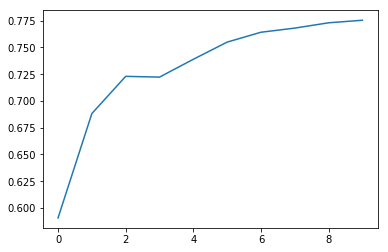

In [79]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Итак, вернемся к графику. Как мы видим, чем больше деревьев мы используем, вычисляя их среднее, тем больше точность нашей модели. И как мы видим, последнее значение на графике совпадает с результатом модели, которую мы сделали вначале главы по **Bagging**.

Попробуем поэксперементировать. Что если удвоить количество деревьев в нашем Random Forest?

In [80]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10176644158422544, 0.3382926406835363, 0.9775245395627987, 0.7956225038638927]


In [81]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0963560546131039, 0.3295823963917139, 0.9798508171648305, 0.806011498472796]


In [82]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09372745638529205, 0.32872361409788703, 0.9809351636483434, 0.8070211206368256]


Как видим, дважды удвоив колво деревьев, мы не получили огромного прироста, но все же он есть! Начальные  **0.750** против **0.766**. Количество деревьев в Random Forest - это первый из так называемых **hyperparametr**'ов, который отвечает за настройку модели. 

## Out-of-bag (OOB) score

Бывает так, что у нас нет достаточного количества данных, чтобы постороить хорошую модель. Что мы делаем в таком случае? Есть один трюк, который довольно уникален для Random Forest - Это использовать те строки из нашего тренировочного датасета, которые не использовались в первом дереве и на основе них построить validation set для этого дерева. То же самое проделать для второго... Потом для все остальных. Таким образом мы получим набор уникальных validation dataset'ов для каждого дерева в Random Forest.

sklearn может сделать это за нас, достаточно передать параметр `oob_score`.

In [83]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09659984536793734, 0.33503017304252924, 0.9797487291605204, 0.7995454967120929, 0.8547434193395034]


Как видим, у нас добавился новый параметр в выводе. Это наш oob_score, который может пригодится для настройки дополнительных hyper-параметров. Для этого воспользуемся gird search. Это scklearn функция, куда мы передаем список всех hyper-параметров, которые мы хотим затюнить, и она прорабатывает нашу модель со всеми возомжными комбинациями этих hyper-параметро, после чего выбирает лучшую. И oob score предоставляет этот выбор.

## Subsampling
Лучший способ избежать переобучения и  ускорить обучение модели - использовать технику под названием subsapmling. Вернемся к использованию всего нашего датасета, чтобы продемонстрировать эту технику.

In [84]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [85]:
len(X_train)

389125

Вместо того, чтобы сознательно ограничивать датасет до 30000, как в прошлый раз, мы будем использовать весь датасет, но при этом функция `set_rf_samples()` будет брать по 20000 сэмплов на дерево, как и в прошлый раз и если у нас будет достаточное кол-во деревьев(Estimators), то наш Random forest покроет весь датасет, что даст бОльшую точность.

In [86]:
set_rf_samples(20000)

Чтобы вернуться к дефолтным настройкам используется функция `reset_rf_samples()`

In [87]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6.76 s, sys: 375 ms, total: 7.13 s
Wall time: 3.43 s
[0.24112960483471382, 0.2808407278447085, 0.8784833201604766, 0.8591463343406823, 0.8658354320326458]


Как мы видим, скорость осталась по-прежнему высокой, а если передать достаточное кол-во деревьев, то точность должна возрасти.

In [88]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22798123506363266, 0.26277309131876975, 0.8913741894198731, 0.8766867470403782, 0.879795277189731]


**0.8755** vs **0.8630** - заметное увеличение точности.

Самое важное, что можно вынести из того, что мы прошли выше - использование малых датасетов. Они дают точно такие же инсайты касательно данных и возможности улучшения модели, но занимают НАМНОГО меньше времени для проверки гипотез. Очень мало людей в индустрии поступают именно таким образом. Чаще всего все тратят часы на прогон алгоритмов на полных данных... Часто еще бывает и так, что данных - МИЛЛИОНЫ! Если каждое дерево будет обучаться на этих данных, то это займет очень много времени. Поэтому с помощью `set_rf_samples()` можно сознательно ограничить сабсет для каждого дерева.

Откатим наш датасет обратно, чтобы не использовать сэмплы по 20к.

In [89]:
reset_rf_samples()

## Три параметра построения Random Forest

Построим заново нашу модель на полных данных.

In [90]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07853858761386709, 0.23942741649078253, 0.987108572813576, 0.8976245714627685, 0.9081702403879317]


Как видим, наш oob score лучше, чем реальное предсказание. Все потому что наш validation set это другой временной ряд, а не рандомный сэмпл, что намного сложнее для предсказания.

Теперь обсудим параметры, которые можно тюнить, чтобы добиться лучшей точности модели. Для борьбы с переобучением можно использовать `min_samples_leaf` параметр, который отвечает за глубину дерева в зависимости от оставшихся параметров на ноду дерева. Объясню, что я имею ввиду. Вот рисунок дерева:
![asd](https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/optimized/2X/7/7ce468cbb50a3d544ec059675751b12df984890b_1_532x500.png)

Мы видим, что `samples` уменьшается с каждым бинарным решением. Оно и верно, дерево уходит вглубь и все больше "переобучается". Если мы выставим наш параметр `min_samples_leaf=10`, то наше дерво не уйдет так глубоко вниз. Как только `samples` станет равен 10, дерево перестанет углубляться. Таким образом оно будет лучше обобщать.

In [91]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11510475696016774, 0.23475379858629225, 0.9723101010753527, 0.9015822956274573, 0.9082108865856713]


Мы получили небольшой прирост точности. Следующий параметр, который можно затюнить - `max_features`. Чтобы понять для чего он нужен, представим себе ситуацию, что в наших данных один из столбоцов настолько хорошо дает предсказание, что каждое дерево начинает свое первое бинарное решение именно с него. Тогда почти все деревья будут довольно похожи, что не есть хорошо. Наша задача специально рандомизировать бинарное разбиение, чтобы этого достичь, каждое дерево помимо рандомного сабсета из строк берет рандомный сабсет из столбцов при каждом бинарном разбиении. Очень похоже на то, что мы уже делали - row sampling, когда каждое новое дерево базировалось на рандомном наборе строк. При column sampling каждое бинарное разбиение использует рандомный набор столбцов.

В нашем случае `max_features=0.5` говорит о том, чтобы при каждом бинарном разбиении рандомно испльзовалась только половина столбцов.

In [92]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11912226122522347, 0.22768954561481977, 0.9703434461583845, 0.9074163805980959, 0.9116179867438973]


Как видим, мы еще немного улучшили наши результаты.
Чаще всего используются следующие фичи:
- 0.5
- sqrt
- log2

sklearn доки [показывают пример](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) разных `max_features` методов с растущим количеством деревьев - как видно, использование max_features требует использования большего количества деревьев, но приводит к улучшению моделей
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)